Epoch 1/10, Loss: 0.3748
Epoch 2/10, Loss: 0.3111
Epoch 3/10, Loss: 0.3020
Epoch 4/10, Loss: 0.2965
Epoch 5/10, Loss: 0.2942
Epoch 6/10, Loss: 0.2916
Epoch 7/10, Loss: 0.2899
Epoch 8/10, Loss: 0.2877
Epoch 9/10, Loss: 0.2864
Epoch 10/10, Loss: 0.2849
LSTM Accuracy: 85.78%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84     15993
         1.0       0.79      0.98      0.87     15993

    accuracy                           0.86     31986
   macro avg       0.88      0.86      0.86     31986
weighted avg       0.88      0.86      0.86     31986



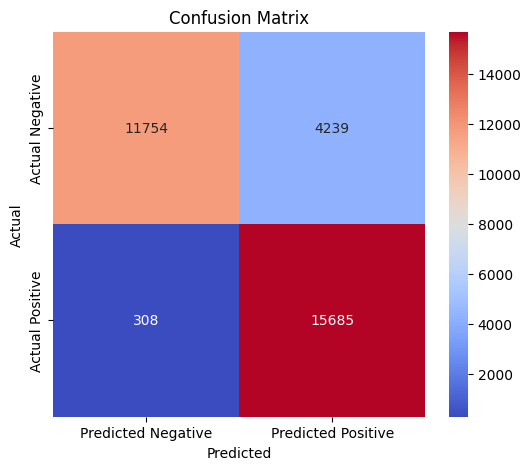

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Load Data
train_path = 'UNSW_NB15_training-set.parquet'
test_path = 'UNSW_NB15_testing-set.parquet'
df_train = pd.read_parquet(train_path)
df_test = pd.read_parquet(test_path)

df = pd.concat([df_train, df_test])
df = shuffle(df)

df.drop_duplicates(keep='first', inplace=True)

# Encode Categorical Columns
label_encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=['category', 'object']).columns
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Handle Class Imbalance using SMOTE
X = df.drop('label', axis=1)
y = df['label']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

# Feature Selection and Normalization
auth_features = ['dur', 'proto', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'tcprtt', 'synack', 'ackdat']
scaler = StandardScaler()
df[auth_features] = scaler.fit_transform(df[auth_features])

# Prepare Data for LSTM
X = df[auth_features].values.reshape(df.shape[0], len(auth_features), 1)
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.fc2 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Take last output
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=1, hidden_size=64, output_size=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Predictions & Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred.extend((outputs.cpu().numpy() > 0.5).astype(int))
        y_true.extend(y_batch.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred) * 100
print(f"LSTM Accuracy: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()